In [1]:
!python --version

Python 2.7.12 :: Anaconda 2.3.0 (x86_64)


In [3]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
from scipy import integrate
import time
%matplotlib inline

In [106]:
def energies_rs(a,b,gamma,N):
    ''' Returns an array of photon energies with a power law distribution using rejection sampling.
        a = E_min
        b = E_max
        gamma = photon index
        N = total number of photons to be returned
    '''
    start_time = time.time()
    A = (1.-gamma)/((b**(1.-gamma))-(a**(1.-gamma))) #normalization factor so curve integrates to 1
    pl =  lambda x,A,gamma : A*x**(-1.0*gamma)
    binsize = 0.13 #keV, set by Chandra detector. This will be swapped out later for a more realistic binning
    bins = np.arange(a,b,binsize)
    photons = np.zeros(N)
    count = 0
    while count<N:
        r = np.random.uniform(a,b,1)
        for i in range(len(bins)-1):
            if (r>bins[i])and(r<bins[i+1]):
                edge_lo = bins[i]
                edge_hi = bins[i+1]
                p_r = integrate.quad(pl,edge_lo,edge_hi,args=(A,gamma))[0]
                k = np.random.uniform(0,1,1)
                if (k<=p_r):
                    photons[count] = r
                    count += 1
    print("Time to generate photon energies = %s seconds" % (time.time() - start_time))
    return photons

In [4]:
def energies_cdf(a,b,gamma,N):
    '''
    Generate photon energies using the cumulative distribution function (CDF)
    CDF taken from https://arxiv.org/pdf/0706.1062.pdf
    a = E_min
    b = E_max
    gamma = photon index
    N = total number of photons to be returned'''
    start_time = time.time()
    r = np.random.uniform(0,1,N)
    x = a*(1-r)**(-1/(gamma-1))
    print("Time to generate photon energies = %s seconds" % (time.time() - start_time))
    return x

Time to generate photon energies = 0.00324892997742 seconds


(array([  4.99020000e+04,   7.00000000e+01,   9.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00]),
 array([  0.10000251,   3.84143819,   7.58287387,  11.32430955,
         15.06574523,  18.8071809 ,  22.54861658,  26.29005226,
         30.03148794,  33.77292362,  37.51435929]),
 <a list of 10 Patch objects>)

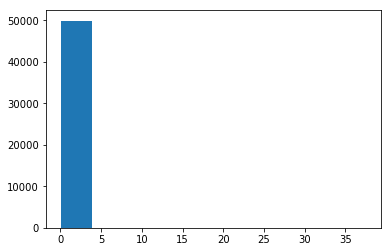

In [183]:
energies = energies_cdf(0.1,10.,2.7,50000)
plt.hist(energies)

Chandra ACIS energy resolution = 130-280 eV (http://cxc.harvard.edu/cal/Acis/)

In [8]:
def simulate_data(stop,handle):
    ''' Generates an un-piled and piled list of photon energies. 
        stop = end time of observation, generally equals total length of obs in seconds.
        handle = 'rs' to generate photons via rejection 
    '''
    #Assign physical parameters
    start = 0. #s
    #stop = 100 #s
    cr = 1. #count rate between 0.1 and 10 photons/second
    gamma = 2.7 #assume photon index
    read_time = 3.2 #s
    energy_lo = 0.1 #keV
    energy_hi = 10.0 #keV
    K = (stop-start)*cr #Number of photons to generate
    N = np.random.poisson(K) #choose a number of photons from a poisson distribution centered on expected, K
    print 'number of photons observed =', N
    
    #Assign photon arrival times, random within obervation time
    arrival_times = np.random.uniform(start,stop,N)
    
    #Assign photon energies, random with a power law distribution.
    if handle == 'rs':
        print 'generating photon energies via rejection sampling'
        energy = energies_rs(energy_lo,energy_hi,gamma,N) #generate photon energies using rejection sampling
    if handle == 'cdf':
        print 'generating photon energies via CDF method'
        energy = energies_cdf(energy_lo,energy_hi,gamma,N)
    else:
        print 'invalid photon generation method entered'
        
    #Simulate pile up: bin arrival times, if there is more than one photon in a bin, combine their energies
    #and record as one photon, change other photon energies to 0
    piled_energy = np.copy(energy)
    times = Column(arrival_times,name='time')
    energies = Column(energy,name='energy')
    raw = Table([times,energies])
    raw.sort('time')
    time_bins = np.arange(start,stop,read_time)
    time_hist, time_edges = np.histogram(raw['time'],bins=time_bins)
    num_piled = 0
    for i in range(len(time_hist)):
        if time_hist[i] > 1:
            #print time_hist[i]
            num_piled += time_hist[i]
            first_photon = np.sum(time_hist[0:i])
            last_photon = first_photon + time_hist[i] - 1
            sum_energy = np.sum(energies[first_photon:last_photon])
            piled_energy[first_photon] = sum_energy
            piled_energy[first_photon+1:last_photon] = 0.0
    print 'Fraction of photons that are piled =', np.float(num_piled) / N
    return energy, piled_energy

In [12]:
def plot_data(raw,piled):
    '''
    Takes output data from simulate_data() and plots the raw vs. piled spectra
    '''
    arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
    fig,ax=plt.subplots(figsize=(8,5))
    #num=len(raw)/50.
    e_hist, e_bins = np.histogram(raw,bins=arf['ENERG_HI'])
    pe_hist, pe_bins = np.histogram(piled[piled>0],bins=arf['ENERG_HI'])
    ax.plot(e_bins[1:],e_hist,label='un-piled')
    ax.plot(pe_bins[1:],pe_hist,label='piled')
    ax.set_xlabel('Energy (keV)')
    ax.set_xlim(-0.5,11)
    ax.set_ylabel('Flux, unscaled')
    ax.set_yscale('log')
    ax.legend()

number of photons observed = 49919
generating photon energies via rejection sampling
Time to generate photon energies = 607.479100943 seconds
invalid photon generation method entered
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
number of piled photons = 47865


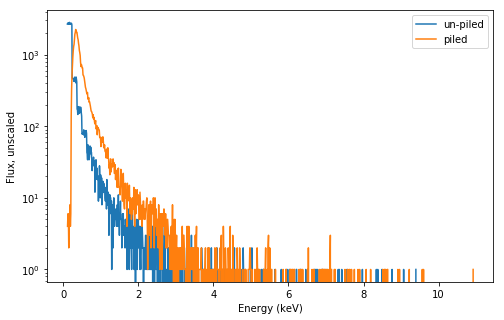

In [174]:
energy,piled_energy = simulate_data(5000,'rs')
plot_data(energy,piled_energy)

number of photons observed = 500332
generating photon energies via CDF method
Time to generate photon energies = 0.0325829982758 seconds
Fraction of photons that are piled = 0.959376973689


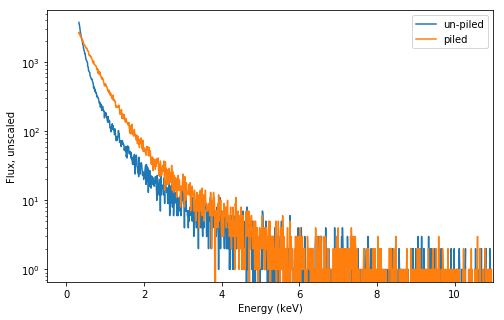

In [13]:
energy,piled_energy = simulate_data(500000,'cdf')
plot_data(energy,piled_energy)

Notes from meeting 2/13
Sort arrival time array by arrival time to speed things up
Use np.histogram (with frame time as bin width) and choose all bins with histogram value of greater than 1

Making photon energies from power law distribution:
Pick r randomly out of [E_0,E_max]
Compute P(r) where P(r) is a power law with a cutoff at E_0 and E_max that integrates to 1
Pick a random number between [0,1], k
If k<= r: keep r in N_s
Else: discard r
Do this while N_s <= N (where N is the total number of photons desired)

Separate plotting and data generation

In [137]:
pi = fits.open('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.pi')
pi[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis                            
NAXIS2  =                 1024 / length of data axis                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'WMAP    '           / ASCDM block name                               
EXTNAME = 'WMAP    '           / Weighted image map                             
HDUCLASS= 'OGIP    '           / GSFC HEASARC                                   
HDUCLAS1= 'IMAGE   '           / GSFC HEASARC                                   
HDUCLAS2= 'WMAP    '        

In [179]:
pi_file = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.pi',format='fits')
#pi_file.info()
rmf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.rmf',format='fits')
arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
arf.info()

<Table length=1070>
  name    dtype  unit
-------- ------- ----
ENERG_LO float32  keV
ENERG_HI float32  keV
SPECRESP float32  cm2
PSF_FRAC float64     


In [180]:
rmf.info()

<Table length=1070>
  name    dtype  unit
-------- ------- ----
ENERG_LO float32  keV
ENERG_HI float32  keV
   N_GRP   int16     
  F_CHAN  object     
  N_CHAN  object     
  MATRIX  object   au


In [181]:
rmf[:3]

ENERG_LO,ENERG_HI,N_GRP,F_CHAN,N_CHAN,MATRIX
keV,keV,,,,au
float32,float32,int16,object,object,object
0.3,0.31,1,[8],[22],[ 1.33990514e-04 5.17258944e-04 8.11043661e-04 1.40370813e-03 2.76047736e-03 5.98445674e-03 1.32914651e-02 2.62204353e-02 4.57122847e-02 7.19392896e-02 1.03447609e-01 1.37926668e-01 1.60626426e-01 1.59799233e-01 1.31819963e-01 8.37430432e-02 3.83864231e-02 1.24285920e-02 2.65758089e-03 3.76633106e-04 4.19869175e-05 5.06864717e-06]
0.31,0.32,1,[8],[23],[ 9.07238500e-05 3.61033948e-04 5.07124583e-04 8.31684156e-04 1.59907318e-03 3.56353750e-03 8.12367909e-03 1.69934612e-02 3.13935205e-02 5.23598343e-02 8.03295523e-02 1.13567561e-01 1.45902410e-01 1.61227465e-01 1.52470320e-01 1.18846811e-01 7.06878528e-02 3.02812606e-02 8.91064759e-03 1.68976700e-03 2.43064351e-04 2.56862422e-05 2.79664641e-06]
0.32,0.33,1,[8],[24],[ 7.56381341e-05 2.44768598e-04 3.61079263e-04 5.42814319e-04 9.98631818e-04 2.13033310e-03 4.82715853e-03 1.03691230e-02 2.07884293e-02 3.73287201e-02 5.98611310e-02 8.94164667e-02 1.23824663e-01 1.51032314e-01 1.59358710e-01 1.44000843e-01 1.06210634e-01 5.86493015e-02 2.26814561e-02 6.02330267e-03 1.12043752e-03 1.94821012e-04 4.74476947e-05 4.84188558e-06]


In [146]:
print len(arf),len(pi_file)

1070 1024


In [148]:
arf[0:1024]

ENERG_LO,ENERG_HI,SPECRESP,PSF_FRAC
keV,keV,cm2,
float32,float32,float32,float64
0.3,0.31,1.82536,0.971443410296
0.31,0.32,5.90961,0.971214969489
0.32,0.33,8.77798,0.970986528002
0.33,0.34,11.8856,0.970758087195
0.34,0.35,14.7305,0.970529646389
0.35,0.36,17.204,0.970301204901
0.36,0.37,19.3461,0.970072764095
0.37,0.38,21.9079,0.969844323288


In [139]:
pi_file['PI']

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0


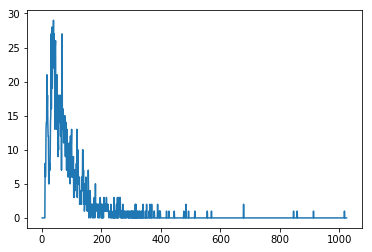

In [134]:
plt.plot(pi_file['CHANNEL'],pi_file['COUNTS'])

##### Questions<br>
1. I'm struggling to understand how to connect the log likelihood expression to my data. I did some reading about it and found a Poisson log(likelihood) expression online:<br>
$l(\lambda;x_{1}...,x_{n}) = -n \lambda - \sum_{j=1}^{n} ln(x_{j}!) + ln(\lambda)\sum_{j=1}^{n}x_{j}$<br>
I think that the x values are the parameter values that I am computing the liklihood for, but what is $\lambda$?<br>
2. For the log(priors) am I writing down an analytic expression for the probability distributions or am I writing a random number generator that will generate values within a given probability distribution? I assume the analytic one, but in that case, I'm just not sure how to write an expression for the uniform distributions.<br>
3. The posterior distribution takes in one value of each parameter and outputs a single value? In the case of our data, is that single value a photon energy? Or a distriution of values?

In [16]:
def log_likelihood(data,logA,a):
    """
    Return log(Poisson likelihood) function for dataset
    Poisson probability of the form P(k) = exp(-lambda)*lambda**k/k!
    lambda = integral from E_min to E_max A*E**-a
    input data = piled histogram from previous step
    """
    arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
    #lam = np.zeros(len(data))
    E_min = arf['ENERG_LO']
    E_max = arf['ENERG_HI']
    f = lambda x: np.exp(logA)*np.power(x,-1.0*a)
    lam = scipy.integrate.quad(f,E_min,E_max)
    summation = np.zeros(len(data))
    for i in range(len(data)):
        to_sum = np.arange(0,data[i]+1,1)
        summation[i]=np.sum(to_sum)
    log_like = -1.0*lam + data*np.log(lam)-summation
    return np.sum(log_like)